In [2]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [6]:
cntry_cntry_df = pd.read_csv("..//..//..//data//Data//DerivedData//Derived//funding_source_target.csv")
cntry_cntry_df = cntry_cntry_df.pivot_table(
    index='source',columns='target', values='value', fill_value=0)
cntry_cntry_df.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.333333,...,2.299242,0.0,0.0,0.0,0.0,0.0,0.50,0.000000,0.0,0.0
Albania,0.0,8.833333,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.277778,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.00,0.000000,0.0,0.0
Algeria,0.0,0.000000,1706.342726,0.0,0.000000,0.0,0.0,3.92619,0.0,1.997885,...,21.937491,0.0,0.0,0.0,0.0,0.0,0.25,0.333333,0.0,0.0
Andorra,0.0,0.000000,0.000000,3.5,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,3.900000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
Angola,0.0,0.000000,0.000000,0.0,20.581349,0.0,0.0,0.00000,0.0,2.650000,...,3.602381,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0


In [7]:
cntry_out = cntry_cntry_df.sum(axis=1).reset_index(name="unitsout")
cntry_in = cntry_cntry_df.sum(axis=0).reset_index(name='unitsin')
cntry_in_out=cntry_in.merge(
    cntry_out, left_on="target",right_on="source",how="inner")
cntry_in_out.head()

,target,unitsin,source,unitsout
0,Afghanistan,95.035440,Afghanistan,23.0
1,Albania,207.108642,Albania,34.0
2,Algeria,4864.172289,Algeria,2607.0
3,Andorra,25.181734,Andorra,53.0
4,Angola,204.422412,Angola,76.0


In [17]:
pubs_author_funder = pd.read_csv("..//..//..//data//Data//DerivedData//CleanedRawData//pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(literal_eval)
pubs_author_funder['funding_units'] = pubs_author_funder['funder_country'].apply(lambda x: len(x))

In [6]:
pubs_author_reshuffle=pd.read_csv("pubs_author_shuffled.csv")
pubs_author_reshuffle['author_country']=pubs_author_reshuffle['author_country'].apply(
    literal_eval)
pubs_author_reshuffle.head()

,id,author_country
0,30507292,"[Turkey, Turkey]"
1,30574690,"[France, United States]"
2,30574691,[Russia]
3,30585095,"[Spain, Spain]"
4,30585097,"[Spain, Spain, Spain, Germany, Germany]"


In [10]:
pubs_author_reshuffle = pubs_author_reshuffle.merge(
    pubs_author_funder[['id','funder_country','funding_units']], on="id")

In [11]:
pubs_author_reshuffle.head()

,id,author_country,funder_country,funding_units
0,30507292,"[Turkey, Turkey]",[Turkey],1
1,30574690,"[France, United States]","[United States, United States, United States, ...",4
2,30574691,[Russia],[Russia],1
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",6
4,30585097,"[Spain, Spain, Spain, Germany, Germany]",[Spain],1


In [13]:
def generate_null(data):
    cntry_cntry_explodelist = []
    for index, row in data.iterrows():
        units = row['funding_units']
        author_country = row['author_country']
        funding_country=row['funder_country']
        num_author = len(author_country)
        num_funder=len(funding_country)
        for author_c in author_country:
            for funder_c in funding_country:
                credit = units/(num_author*num_funder)
                templist = [funder_c,author_c, credit]
                cntry_cntry_explodelist.append(templist)
                
    cntry_cntry_null = pd.DataFrame(
        cntry_cntry_explodelist, columns=['source','target','value'])
    cntry_cntry_null = cntry_cntry_null.groupby(['source','target'])['value'].sum().reset_index()
    cntry_cntry_null = cntry_cntry_null.pivot_table(
        index='source',columns='target', values='value', fill_value=0)
    return cntry_cntry_null


In [18]:
def get_normedmatrix(indexlist, collist, actual_df, random_df):
    
    randomnormed_df = pd.DataFrame(
        index=indexlist,columns=collist)
    for ind, col in product(indexlist, collist):
        try:
            actual_value=actual_df.loc[ind,col]
        except:
            actual_value=0
        random_value=random_df.loc[ind,col]
        exp=actual_value/random_value
        randomnormed_df.loc[ind,col]=exp
    randomnormed_df = randomnormed_df.fillna(0)
    
    return randomnormed_df


In [14]:
author_null_matrix = generate_null(pubs_author_reshuffle)

In [19]:
author_null_matrix.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.714286,...,2.667949,0.0,0.0,0.0,0.0,0.0,0.833333,0.000000,0.0,0.0
Albania,0.0,8.333333,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.311111,...,0.600000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0
Algeria,0.0,0.000000,1597.741963,0.0,0.000000,0.0,0.0,4.674603,0.0,2.675996,...,26.579111,0.0,0.0,0.0,0.0,0.0,0.400000,0.166667,0.0,0.0
Andorra,0.0,0.000000,0.000000,3.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,4.607143,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
Angola,0.0,0.000000,0.000000,0.0,23.285786,0.0,0.0,0.000000,0.0,5.785714,...,3.182612,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [20]:
cntry_cntry_df.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.333333,...,2.299242,0.0,0.0,0.0,0.0,0.0,0.50,0.000000,0.0,0.0
Albania,0.0,8.833333,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.277778,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.00,0.000000,0.0,0.0
Algeria,0.0,0.000000,1706.342726,0.0,0.000000,0.0,0.0,3.92619,0.0,1.997885,...,21.937491,0.0,0.0,0.0,0.0,0.0,0.25,0.333333,0.0,0.0
Andorra,0.0,0.000000,0.000000,3.5,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,3.900000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
Angola,0.0,0.000000,0.000000,0.0,20.581349,0.0,0.0,0.00000,0.0,2.650000,...,3.602381,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0


In [21]:
funderlist=cntry_cntry_df.index
authorlist=cntry_cntry_df.columns
authornull_normed=get_normedmatrix(
    funderlist, authorlist, cntry_cntry_df, author_null_matrix)

<ipython-input-18-13d4e271a30e>:11: RuntimeWarning: invalid value encountered in double_scalars
  exp=actual_value/random_value


In [22]:
authornull_normed.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.466667,...,0.861802,0.0,0.0,0.0,0.0,0.0,0.600,0.0,0.0,0.0
Albania,0.0,1.06,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.892857,...,1.666667,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,0.0
Algeria,0.0,0.00,1.067971,0.000000,0.000000,0.0,0.0,0.839898,0.0,0.746595,...,0.825366,0.0,0.0,0.0,0.0,0.0,0.625,2.0,0.0,0.0
Andorra,0.0,0.00,0.000000,1.166667,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.846512,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0
Angola,0.0,0.00,0.000000,0.000000,0.883859,0.0,0.0,0.000000,0.0,0.458025,...,1.131895,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0


In [3]:
authornull_normed=pd.read_csv("authornull_normed.csv", index_col=0)

In [4]:
import matplotlib.colors as colors
divnorm = colors.DivergingNorm(vmin=0, vcenter=1, vmax=9)

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


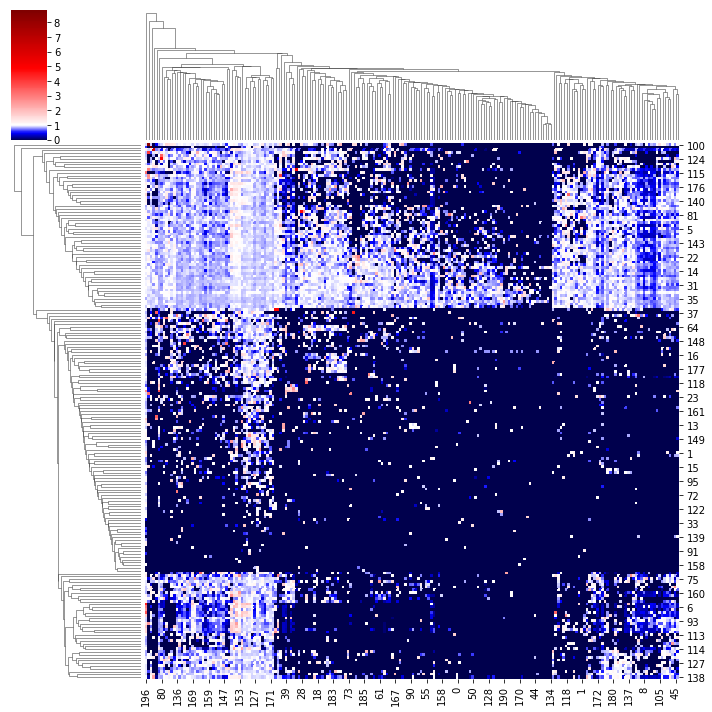

In [5]:
g = sns.clustermap(authornull_normed.values,norm=divnorm,cmap="seismic")

In [8]:
top20 = cntry_in_out.sort_values(
    by='unitsout',ascending=False).head(20).source

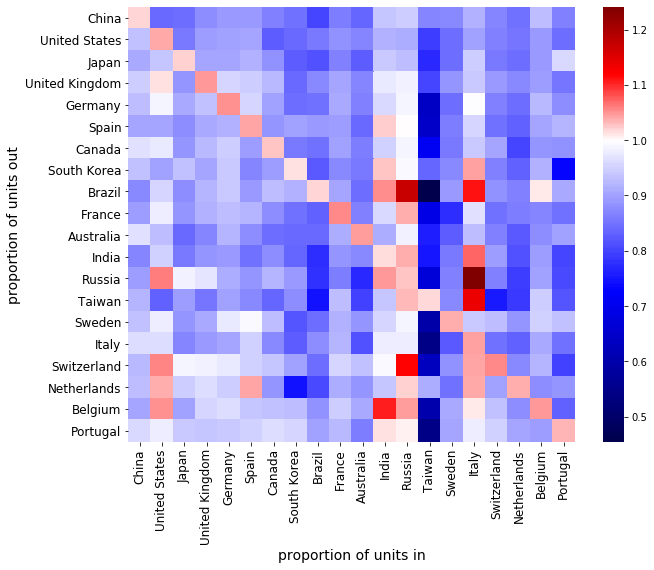

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(authornull_normed.loc[top20,top20],norm=divnorm,cmap="seismic")
plt.ylabel("proportion of units out", fontsize=14)
plt.xlabel("proportion of units in", fontsize=14)
plt.tick_params(axis='both',labelsize=12)

In [43]:
authornull_normed.loc['China',authornull_normed.loc['China',:]>1]

target
Angola                      1.324389
Bahamas                     1.237609
Bahrain                     1.120728
Benin                       1.086132
Bhutan                      1.062592
Burkina Faso                1.080327
Central African Republic    1.448468
China                       1.019919
Cuba                        1.015327
El Salvador                 1.090909
French-Polynesia            1.068661
Lebanon                     1.106756
Lesotho                     1.090909
Liechtenstein               1.420078
Malawi                      1.029255
Mali                        1.018933
Malta                       1.155518
Moldova                     1.017109
Montenegro                  1.139832
Nauru                       1.015873
New-Caledonia               1.009114
Nicaragua                   1.852406
North Korea                 1.083266
Solomon Islands             1.182690
South Sudan                 1.388889
Sudan                       1.037139
Swaziland                   1.0